In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

from gptchem.data import get_hea_phase_data
from gptchem.evaluator import (
    evaluate_classification,
    find_learning_curve_intersection,
    fit_learning_curve,
    lc,
)
from gptchem.formatter import ClassificationFormatter
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH


from gptchem.plotsettings import *

%matplotlib inline

## Get the dummy metrics

In [28]:
data = get_hea_phase_data()

In [29]:
estimators = ["uniform", "stratified", "most_frequent"]
results = []
train_sizes = [10, 20, 50, 100, 200]
for i in range(10):
    for estimator in estimators:
        for train_size in train_sizes:
            train, test = train_test_split(
                data,
                train_size=train_size,
                test_size=250,
                stratify=data["phase_binary_encoded"],
                random_state=i,
            )
            classifier = DummyClassifier(strategy=estimator)
            classifier.fit(train["Alloy"], train["phase_binary_encoded"])
            predictions = classifier.predict(test["Alloy"])
            res = evaluate_classification(test["phase_binary_encoded"], predictions)
            res["train_size"] = train_size
            res["estimator"] = estimator
            results.append(res)

In [30]:
dummy_results = pd.DataFrame(results)

In [31]:
dummy_grouped = (
    dummy_results[["train_size", "estimator", "accuracy", "f1_macro", "f1_micro", "kappa"]]
    .groupby(["estimator", "train_size"])
    .agg(["mean", "std", sem])
)

In [32]:
dummy_grouped

accuracy                      f1_macro            \
                             mean       std       sem      mean       std   
estimator     train_size                                                    
most_frequent 10           0.5000  0.000000  0.000000  0.333333  0.000000   
              20           0.5000  0.000000  0.000000  0.333333  0.000000   
              50           0.5000  0.000000  0.000000  0.333333  0.000000   
              100          0.5000  0.000000  0.000000  0.333333  0.000000   
              200          0.5000  0.000000  0.000000  0.333333  0.000000   
stratified    10           0.4948  0.025302  0.008001  0.494512  0.025367   
              20           0.5132  0.021994  0.006955  0.512760  0.021897   
              50           0.4924  0.030952  0.009788  0.491727  0.030926   
              100          0.4912  0.027182  0.008596  0.490349  0.027697   
              200          0.4968  0.034244  0.010829  0.496274  0.034179   
uniform       10           0.5188  0.034772  0.010996  0.518331  0.034735   
              20           0.5068  0.028350  0.008965  0.506051  0.028772   
              50           0.5056  0.032779  0.010366  0.504972  0.032722   
              100          0.5004  0.041503  0.013124  0.499531  0.041651   
              200          0.4972  0.039600  0.012523  0.496596  0.039759   

                                       f1_micro                       kappa  \
                                   sem     mean       std       sem    mean   
estimator     train_size                                                      
most_frequent 10          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              20          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              50          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              100         1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              200         1.850372e-17   0.5000  0.000000  0.000000  0.0000   
stratified    10          8.021628e-03   0.4948  0.025302  0.008001 -0.0104   
              20          6.924481e-03   0.5132  0.021994  0.006955  0.0264   
              50          9.779603e-03   0.4924  0.030952  0.009788 -0.0152   
              100         8.758490e-03   0.4912  0.027182  0.008596 -0.0176   
              200         1.080833e-02   0.4968  0.034244  0.010829 -0.0064   
uniform       10          1.098405e-02   0.5188  0.034772  0.010996  0.0376   
              20          9.098466e-03   0.5068  0.028350  0.008965  0.0136   
              50          1.034774e-02   0.5056  0.032779  0.010366  0.0112   
              100         1.317129e-02   0.5004  0.041503  0.013124  0.0008   
              200         1.257288e-02   0.4972  0.039600  0.012523 -0.0056   

                                              
                               std       sem  
estimator     train_size                      
most_frequent 10          0.000000  0.000000  
              20          0.000000  0.000000  
              50          0.000000  0.000000  
              100         0.000000  0.000000  
              200         0.000000  0.000000  
stratified    10          0.050603  0.016002  
              20          0.043988  0.013910  
              50          0.061905  0.019576  
              100         0.054363  0.017191  
              200         0.068487  0.021658  
uniform       10          0.069543  0.021992  
              20          0.056700  0.017930  
              50          0.065559  0.020732  
              100         0.083006  0.026249  
              200         0.079200  0.025045

## Load the results

### Automatminer

In [33]:
automatminer_out = glob("out-baseline/**/*.pkl")

In [34]:
extracted_automatminer_res = []

for out in automatminer_out:
    out = load_pickle(out)
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    extracted_automatminer_res.append(res)

In [35]:
extracted_automatminer_res = pd.DataFrame(extracted_automatminer_res)

In [36]:
extracted_automatminer_res_grouped = extracted_automatminer_res.groupby("train_size").agg(
    ["mean", "std", "sem"]
)

### GPT

In [37]:
all_out = glob("out/**/*.pkl")

In [38]:
all_out = [load_pickle(p) for p in all_out]

In [39]:
extracted_res = []

for out in all_out:
    res = {
        "base_model": out["base_model"],
        "train_size": out["train_size"],
        "test_size": out["test_size"],
        "n_epochs": out["n_epochs"],
        "learning_rate_multiplier": out["learning_rate_multiplier"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    extracted_res.append(res)

In [40]:
extracted_res = pd.DataFrame(extracted_res)

In [41]:
extracted_res_grouped = extracted_res.groupby(["train_size"]).agg(["mean", "std", sem])

In [42]:
extracted_res_grouped

test_size           n_epochs           learning_rate_multiplier  \
                mean  std  sem     mean  std  sem                     mean   
train_size                                                                   
10             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
20             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
50             250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
100            250.0  0.0  0.0      8.0  0.0  0.0                     0.02   
200            250.0  0.0  0.0      8.0  0.0  0.0                     0.02   

                              frac_valid  ...  accuracy  f1_macro            \
            std           sem       mean  ...       sem      mean       std   
train_size                                ...                                 
10          0.0  1.156482e-18        1.0  ...  0.014498  0.884522  0.047488   
20          0.0  1.156482e-18        1.0  ...  0.017266  0.890336  0.056011   
50          0.0  1.156482e-18        1.0  ...  0.010506  0.932225  0.033577   
100         0.0  0.000000e+00        1.0  ...  0.005310  0.960406  0.015974   
200         0.0  1.156482e-18        1.0  ...  0.002696  0.964376  0.008544   

                      f1_micro                         kappa            \
                 sem      mean       std       sem      mean       std   
train_size                                                               
10          0.015017  0.885600  0.045848  0.014498  0.771200  0.091696   
20          0.017712  0.891600  0.054600  0.017266  0.783200  0.109200   
50          0.010618  0.932400  0.033224  0.010506  0.864800  0.066448   
100         0.005325  0.960444  0.015930  0.005310  0.920889  0.031861   
200         0.002702  0.964400  0.008527  0.002696  0.928800  0.017054   

                      
                 sem  
train_size            
10          0.028997  
20          0.034532  
50          0.021013  
100         0.010620  
200         0.005393  

[5 rows x 24 columns]

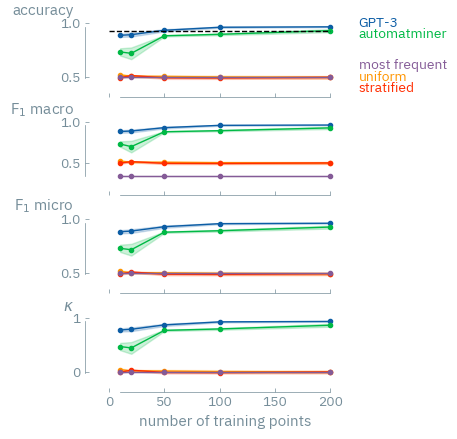

In [43]:

fig, ax = plt.subplots(
    4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
)

# accuracy
ax[0].plot(
    extracted_res_grouped.index,
    extracted_res_grouped["accuracy"]["mean"],
    marker="o",
    label="GPT-3",
)
ax[0].fill_between(
    extracted_res_grouped.index,
    extracted_res_grouped["accuracy"]["mean"] - extracted_res_grouped["accuracy"]["sem"],
    extracted_res_grouped["accuracy"]["mean"] + extracted_res_grouped["accuracy"]["sem"],
    alpha=0.2,
    color="C0",
)

ax[0].plot(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["accuracy"]["mean"],
    marker="o",
    label="automatminer",
)

ax[0].fill_between(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["accuracy"]["mean"]
    - extracted_automatminer_res_grouped["accuracy"]["sem"],
    extracted_automatminer_res_grouped["accuracy"]["mean"]
    + extracted_automatminer_res_grouped["accuracy"]["sem"],
    alpha=0.2,
    color="C1",
)

# add the dummy models
for i, estimator in enumerate(estimators):
    ax[0].plot(
        dummy_grouped.loc[estimator, :]["accuracy"]["mean"].index,
        dummy_grouped.loc[estimator, :]["accuracy"]["mean"],
        label=estimator.replace("_", " "),
        marker="o",
        color=f"C{i+2}",
    )
    ax[0].fill_between(
        dummy_grouped.loc[estimator, :]["accuracy"]["mean"].index,
        dummy_grouped.loc[estimator, :]["accuracy"]["mean"]
        - dummy_grouped.loc[estimator, :]["accuracy"]["sem"],
        dummy_grouped.loc[estimator, :]["accuracy"]["mean"]
        + dummy_grouped.loc[estimator, :]["accuracy"]["sem"],
        alpha=0.2,
        color=f"C{i+2}",
    )


range_frame(ax[0], extracted_res_grouped.index, np.stack([extracted_res_grouped["accuracy"]["mean"]] + [ dummy_grouped.loc[estimator, :]["accuracy"]["mean"] for estimator in estimators]).flatten())


# f1 macro
ax[1].plot(
    extracted_res_grouped.index,
    extracted_res_grouped["f1_macro"]["mean"],
    label="GPT-3",
    marker="o",
)
ax[1].fill_between(
    extracted_res_grouped.index,
    extracted_res_grouped["f1_macro"]["mean"] - extracted_res_grouped["f1_macro"]["sem"],
    extracted_res_grouped["f1_macro"]["mean"] + extracted_res_grouped["f1_macro"]["sem"],
    alpha=0.2,
    color="C0",
)

ax[1].plot(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["f1_macro"]["mean"],
    label="automatminer",
    marker="o",
)
ax[1].fill_between(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["f1_macro"]["mean"]
    - extracted_automatminer_res_grouped["f1_macro"]["sem"],
    extracted_automatminer_res_grouped["f1_macro"]["mean"]
    + extracted_automatminer_res_grouped["f1_macro"]["sem"],
    alpha=0.2,
    color="C1",
)

# add the dummy models
for i, estimator in enumerate(estimators):
    ax[1].plot(
        dummy_grouped.loc[estimator, :]["f1_macro"]["mean"].index,
        dummy_grouped.loc[estimator, :]["f1_macro"]["mean"],
        label=estimator.replace("_", " "),
        marker="o",
        color=f"C{i+2}",
    )
    ax[1].fill_between(
        dummy_grouped.loc[estimator, :]["f1_macro"]["mean"].index,
        dummy_grouped.loc[estimator, :]["f1_macro"]["mean"]
        - dummy_grouped.loc[estimator, :]["f1_macro"]["sem"],
        dummy_grouped.loc[estimator, :]["f1_macro"]["mean"]
        + dummy_grouped.loc[estimator, :]["f1_macro"]["sem"],
        alpha=0.2,
        color=f"C{i+2}",
    )


range_frame(ax[1], extracted_res_grouped.index, np.stack([extracted_res_grouped["f1_macro"]["mean"]] + [ dummy_grouped.loc[estimator, :]["f1_macro"]["mean"] for estimator in estimators]).flatten())

# f1 micro

ax[2].plot(
    extracted_res_grouped.index,
    extracted_res_grouped["f1_micro"]["mean"],
    label="GPT-3",
    marker="o",
)
ax[2].fill_between(
    extracted_res_grouped.index,
    extracted_res_grouped["f1_micro"]["mean"] - extracted_res_grouped["f1_micro"]["sem"],
    extracted_res_grouped["f1_micro"]["mean"] + extracted_res_grouped["f1_micro"]["sem"],
    alpha=0.2,
    color="C0",
)

ax[2].plot(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["f1_micro"]["mean"],
    label="automatminer",
    marker="o",
)
ax[2].fill_between(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["f1_micro"]["mean"]
    - extracted_automatminer_res_grouped["f1_micro"]["sem"],
    extracted_automatminer_res_grouped["f1_micro"]["mean"]
    + extracted_automatminer_res_grouped["f1_micro"]["sem"],
    alpha=0.2,
    color="C1",
)

# add the dummy models
for i, estimator in enumerate(estimators):
    ax[2].plot(
        dummy_grouped.loc[estimator, :]["f1_micro"]["mean"].index,
        dummy_grouped.loc[estimator, :]["f1_micro"]["mean"],
        label=estimator.replace("_", " "),
        marker="o",
        color=f"C{i+2}",
    )
    ax[2].fill_between(
        dummy_grouped.loc[estimator, :]["f1_micro"]["mean"].index,
        dummy_grouped.loc[estimator, :]["f1_micro"]["mean"]
        - dummy_grouped.loc[estimator, :]["f1_micro"]["sem"],
        dummy_grouped.loc[estimator, :]["f1_micro"]["mean"]
        + dummy_grouped.loc[estimator, :]["f1_micro"]["sem"],
        alpha=0.2,
        color=f"C{i+2}",
    )


range_frame(ax[2], extracted_res_grouped.index, np.stack([extracted_res_grouped["f1_micro"]["mean"]] + [ dummy_grouped.loc[estimator, :]["f1_micro"]["mean"] for estimator in estimators]).flatten())



# kappa
ax[3].plot(
    extracted_res_grouped.index,
    extracted_res_grouped["kappa"]["mean"],
    label="GPT-3",
    marker="o",
)
ax[3].fill_between(
    extracted_res_grouped.index,
    extracted_res_grouped["kappa"]["mean"] - extracted_res_grouped["kappa"]["sem"],
    extracted_res_grouped["kappa"]["mean"] + extracted_res_grouped["kappa"]["sem"],
    alpha=0.2,
    color="C0",
)

ax[3].plot(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["kappa"]["mean"],
    label="automatminer",
    marker="o",
)
ax[3].fill_between(
    extracted_automatminer_res_grouped.index,
    extracted_automatminer_res_grouped["kappa"]["mean"]
    - extracted_automatminer_res_grouped["kappa"]["sem"],
    extracted_automatminer_res_grouped["kappa"]["mean"]
    + extracted_automatminer_res_grouped["kappa"]["sem"],
    alpha=0.2,
    color="C1",
)

# add the dummy models
for i, estimator in enumerate(estimators):
    ax[3].plot(
        dummy_grouped.loc[estimator, :]["kappa"]["mean"].index,
        dummy_grouped.loc[estimator, :]["kappa"]["mean"],
        label=estimator.replace("_", " "),
        marker="o",
        color=f"C{i+2}",
    )
    ax[3].fill_between(
        dummy_grouped.loc[estimator, :]["kappa"]["mean"].index,
        dummy_grouped.loc[estimator, :]["kappa"]["mean"]
        - dummy_grouped.loc[estimator, :]["kappa"]["sem"],
        dummy_grouped.loc[estimator, :]["kappa"]["mean"]
        + dummy_grouped.loc[estimator, :]["kappa"]["sem"],
        alpha=0.2,
        color=f"C{i+2}",
    )


range_frame(ax[3], extracted_res_grouped.index, np.stack([extracted_res_grouped["kappa"]["mean"]] + [ dummy_grouped.loc[estimator, :]["kappa"]["mean"] for estimator in estimators]).flatten())



ax[0].hlines(0.93, 0, 200, color="k", linestyle="--")

ylabel_top("accuracy", ax=ax[0],x_pad=0.08, y_pad=-0.01)
ylabel_top(r"F$_{1}$ macro", ax=ax[1],x_pad=0.08, y_pad=-0.05)
ylabel_top(r"F$_{1}$ micro", ax=ax[2],x_pad=0.08, y_pad=-0.03)
ylabel_top(r"$\kappa$", ax=ax[3],x_pad=0.08, y_pad=-0.04)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax[0])
plt.subplots_adjust(hspace=.6, top=1, bottom=.2)
fig.savefig("hea_single_vs_multiphase_classifier.pdf", bbox_inches="tight")

In [44]:
find_learning_curve_intersection(
    extracted_res_grouped["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        extracted_automatminer_res_grouped.index,
        extracted_automatminer_res_grouped["f1_macro"]["mean"],
    )[0],
) / 10

24.14375077364608

In [45]:
dummy_grouped

accuracy                      f1_macro            \
                             mean       std       sem      mean       std   
estimator     train_size                                                    
most_frequent 10           0.5000  0.000000  0.000000  0.333333  0.000000   
              20           0.5000  0.000000  0.000000  0.333333  0.000000   
              50           0.5000  0.000000  0.000000  0.333333  0.000000   
              100          0.5000  0.000000  0.000000  0.333333  0.000000   
              200          0.5000  0.000000  0.000000  0.333333  0.000000   
stratified    10           0.4948  0.025302  0.008001  0.494512  0.025367   
              20           0.5132  0.021994  0.006955  0.512760  0.021897   
              50           0.4924  0.030952  0.009788  0.491727  0.030926   
              100          0.4912  0.027182  0.008596  0.490349  0.027697   
              200          0.4968  0.034244  0.010829  0.496274  0.034179   
uniform       10           0.5188  0.034772  0.010996  0.518331  0.034735   
              20           0.5068  0.028350  0.008965  0.506051  0.028772   
              50           0.5056  0.032779  0.010366  0.504972  0.032722   
              100          0.5004  0.041503  0.013124  0.499531  0.041651   
              200          0.4972  0.039600  0.012523  0.496596  0.039759   

                                       f1_micro                       kappa  \
                                   sem     mean       std       sem    mean   
estimator     train_size                                                      
most_frequent 10          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              20          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              50          1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              100         1.850372e-17   0.5000  0.000000  0.000000  0.0000   
              200         1.850372e-17   0.5000  0.000000  0.000000  0.0000   
stratified    10          8.021628e-03   0.4948  0.025302  0.008001 -0.0104   
              20          6.924481e-03   0.5132  0.021994  0.006955  0.0264   
              50          9.779603e-03   0.4924  0.030952  0.009788 -0.0152   
              100         8.758490e-03   0.4912  0.027182  0.008596 -0.0176   
              200         1.080833e-02   0.4968  0.034244  0.010829 -0.0064   
uniform       10          1.098405e-02   0.5188  0.034772  0.010996  0.0376   
              20          9.098466e-03   0.5068  0.028350  0.008965  0.0136   
              50          1.034774e-02   0.5056  0.032779  0.010366  0.0112   
              100         1.317129e-02   0.5004  0.041503  0.013124  0.0008   
              200         1.257288e-02   0.4972  0.039600  0.012523 -0.0056   

                                              
                               std       sem  
estimator     train_size                      
most_frequent 10          0.000000  0.000000  
              20          0.000000  0.000000  
              50          0.000000  0.000000  
              100         0.000000  0.000000  
              200         0.000000  0.000000  
stratified    10          0.050603  0.016002  
              20          0.043988  0.013910  
              50          0.061905  0.019576  
              100         0.054363  0.017191  
              200         0.068487  0.021658  
uniform       10          0.069543  0.021992  
              20          0.056700  0.017930  
              50          0.065559  0.020732  
              100         0.083006  0.026249  
              200         0.079200  0.025045

In [46]:
dummy_grouped.loc["most_frequent"]

accuracy            f1_macro                    f1_micro            \
               mean  std  sem      mean  std           sem     mean  std  sem   
train_size                                                                      
10              0.5  0.0  0.0  0.333333  0.0  1.850372e-17      0.5  0.0  0.0   
20              0.5  0.0  0.0  0.333333  0.0  1.850372e-17      0.5  0.0  0.0   
50              0.5  0.0  0.0  0.333333  0.0  1.850372e-17      0.5  0.0  0.0   
100             0.5  0.0  0.0  0.333333  0.0  1.850372e-17      0.5  0.0  0.0   
200             0.5  0.0  0.0  0.333333  0.0  1.850372e-17      0.5  0.0  0.0   

           kappa            
            mean  std  sem  
train_size                  
10           0.0  0.0  0.0  
20           0.0  0.0  0.0  
50           0.0  0.0  0.0  
100          0.0  0.0  0.0  
200          0.0  0.0  0.0

In [47]:
input_frame = pd.read_json('/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/03_classification/hea_single_vs_multiphase/out/20230109_155453/train.jsonl', lines=True)

In [48]:
input_frame

,prompt,completion,label,representation
0,What is the phase of Co1Cu1Fe1Ni1V1?###,0@@@,0,Co1Cu1Fe1Ni1V1
1,What is the phase of Pu0.75Zr0.25?###,1@@@,1,Pu0.75Zr0.25
2,What is the phase of BeFe?###,0@@@,0,BeFe
3,What is the phase of LiTa?###,0@@@,0,LiTa
4,What is the phase of Nb0.5Ta0.5?###,1@@@,1,Nb0.5Ta0.5
5,What is the phase of Al0.1W0.9?###,1@@@,1,Al0.1W0.9
6,What is the phase of Cr0.5Fe0.5?###,1@@@,1,Cr0.5Fe0.5
7,What is the phase of Al1Co1Cr1Cu1Fe1Ni1Ti1?###,0@@@,0,Al1Co1Cr1Cu1Fe1Ni1Ti1
8,What is the phase of Cu0.5Mn0.5?###,1@@@,1,Cu0.5Mn0.5
9,What is the phase of OsU?###,0@@@,0,OsU


In [53]:
for i, row in input_frame.iterrows():
    print(row['prompt'] + " & " + str(row['label']) +  " \\\\")

What is the phase of Co1Cu1Fe1Ni1V1?### & 0 \\
What is the phase of Pu0.75Zr0.25?### & 1 \\
What is the phase of BeFe?### & 0 \\
What is the phase of LiTa?### & 0 \\
What is the phase of Nb0.5Ta0.5?### & 1 \\
What is the phase of Al0.1W0.9?### & 1 \\
What is the phase of Cr0.5Fe0.5?### & 1 \\
What is the phase of Al1Co1Cr1Cu1Fe1Ni1Ti1?### & 0 \\
What is the phase of Cu0.5Mn0.5?### & 1 \\
What is the phase of OsU?### & 0 \\
